### Malila Freeeman
### 1368878
### HW #6

In [750]:
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from scipy.special import softmax

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

#### Step 1: Data acquisition + cleanup

In [751]:
df = pd.read_csv("fonts/VIVALDI.csv")

In [752]:
# Makes numpy arrays y and X from a dataframe 
def makeNumpys(inputdf):

    inputdf = inputdf.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)

    y = inputdf['m_label'].values

    # Get all of the unicode unicode characters out of the dataset
    unique_unicode = set(y)

    # Create a dictionary mapping each unique unicode identifier to each label
    unicode_to_label = {}
    label_to_unicode = {}
    for i, c in enumerate(unique_unicode):
        unicode_to_label[c] = i
        label_to_unicode[i] = c

    return_y = np.asarray([unicode_to_label[y_val] for y_val in y])

    # Drop the label from the dataframe and make all of the rest of the columns into X
    new_df = inputdf.drop(['m_label'], axis=1)
    X = new_df.values
    # Divide each value of X by 255
    normalized_X = X/255
    return_X = np.reshape(normalized_X, (-1, 1, 20, 20))

    return return_y, return_X, unicode_to_label, label_to_unicode

# This function is to be used to get the appropriate ys and Xs from a dataframe when a second or third font is added, because the same
# map will need to be used for both fonts 
def makeNumpysWithOtherMap(inputdf, inputmap):

    inputdf = inputdf.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)

    y = inputdf['m_label'].values

    # Get all of the unicode unicode characters out of the dataset
    unique_unicode = set(y)

    unicode_to_label = {}

    for i, c in enumerate(unique_unicode):

        # This will get the same index for the character as the one for the input map
        if (c in inputmap):
            unicode_to_label[c] = inputmap[c]


    ys_in_dict = unicode_to_label.keys()

    # Only keep rows where the y is in the dictionary of the first font so that we don't have characters that weren't trained on
    new_df = inputdf[inputdf['m_label'].isin(ys_in_dict)]

    y = new_df['m_label'].values

    return_y = np.asarray([unicode_to_label[y_val] for y_val in y])


    new_df = new_df.drop(['m_label'], axis=1)
    X = new_df.values
    normalized_X = X/255

    return_X = np.reshape(normalized_X, (-1, 1, 20, 20))

    return return_y, return_X, unicode_to_label

# Get the X and y arrays for vivaldi font
y, X, unicode_to_label, label_to_unicode = makeNumpys(df)

In [753]:
def makeLoaders(X, y):
    X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=1, test_size=0.2 )

    train_tensor_X = torch.from_numpy(X_train).to(torch.float32)
    train_tensor_y = torch.from_numpy(y_train).to(torch.long)
    train_data = TensorDataset(train_tensor_X, train_tensor_y)

    test_tensor_X = torch.from_numpy(X_test).to(torch.float32)
    test_tensor_y = torch.from_numpy(y_test).to(torch.long)
    test_data = TensorDataset(test_tensor_X, test_tensor_y) 

    train_loader = torch.utils.data.DataLoader( train_data, batch_size=8,
                                               shuffle=True, num_workers=0 )

    test_loader = torch.utils.data.DataLoader( test_data, batch_size=8,
                                               shuffle=True, num_workers=0 )

    return train_loader, test_loader
    
# Training and testing loaders for vivaldi font
train_loader, test_loader = makeLoaders(X, y)


def makeLoadersNoSplit(X, y):

    tensor_X = torch.from_numpy(X).to(torch.float32)
    tensor_y = torch.from_numpy(y).to(torch.long)

    data = TensorDataset(tensor_X, tensor_y)

    loader = torch.utils.data.DataLoader( data, batch_size=8,
                                               shuffle=True, num_workers=0 )

    return loader

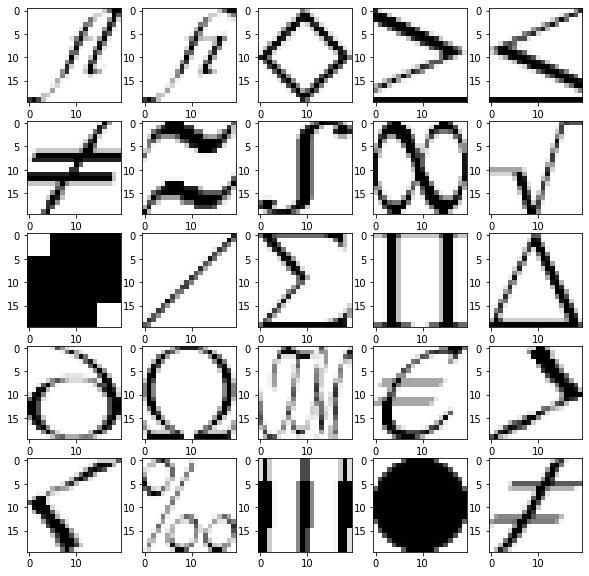

In [754]:
def plotFirst25(X):
    plt.figure( figsize= (10, 10) )

    for ii in np.arange( 25 ):
        plt.subplot( 5, 5, ii+1 )
        plt.imshow( np.reshape(X[ii, :, :, :], (20, 20)), cmap='Greys',interpolation='none' )

    plt.show()

plotFirst25(X)

#### Step 2: Build a pytorch network

In [755]:
class originalNet(nn.Module):
    def __init__(self, y_size):
        super(originalNet, self).__init__()
        c1Out = 6 # convolution layer 1 will output 6 "images": one for each filter it trains
        c2Out = 16 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d( 1, c1Out, 3 ) # 1-D input, c1Out outputs, filter size 3x3 pixels
                
        self.pool = nn.MaxPool2d( 2, 2 ) # down sample 2x2 blocks to 1 value
                
        self.conv2 = nn.Conv2d( c1Out, c2Out, 3 ) # Inputs comes from conv1, specify our #outputs, use 3x3 blocks again
        
        
        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out * 3 * 3 # 16 outputs per image whose size has been reduced
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        self.fc2 = nn.Linear( 120, y_size )

    ################################################################################
    # Take an image (or images) and run it through all stages of the net:
    #    
    def forward( self, x ): # "batch" of images
        # x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))``
        # after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        # after max pool: (batch size, width/2, height/2, conv1 # outputs)
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        x = self.pool(F.relu(self.conv2(x))) #ditto

        # Flatten: turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc2(x) #dense layer 2.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [756]:
def train( model, epochs, trainloader ): # One epoch uses the entire training set (one batch at a time) - 60,000 images in this case
    
    criterion = nn.CrossEntropyLoss() # this is a way of measuring error (loss) for classification that takes the
                                      # "confidence" of a prediction into account.  High confidence, correct predictions are low cost, 
                                      # high confidence, wrong predictions are high cost, medium confidence predictions have cost

    # use the ADAM optimizer to find the best weights
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 ) 
    
    # #this loads data and gets it in the right format for us
    # trainloader = torch.utils.data.DataLoader( X, batch_size=8,
    #                                            shuffle=True, num_workers=0 )

    for epoch in range( epochs ): # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate( trainloader, 0 ):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) #predict the output with some training data
            loss = criterion(outputs, labels) #see how well we did

            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches

                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

                
    print('Finished Training')

def evaluate( model, testloader ):  
    #load some test data
    # testloader = torch.utils.data.DataLoader( X, batch_size=8,
    #                                           shuffle=True, num_workers=0 )
    correct = 0
    total = 0

    with torch.no_grad(): # <- Since we are not training, the model does not need to calculate gradients
        for data in testloader:
            images, labels = data
            outputs = model( images )
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Just do a coarse evaluation... how many did we predict correcly?
    print( 'Accuracy of the network on the test images: %d %%' % ( 100 * correct / total) )

#### Step 3: Exploration and Evaluation

1. Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?

In [760]:
nirmala = pd.read_csv("fonts/NIRMALA.csv")

# Get the X and y arrays for nirmala font
y_nirmala, X_nirmala, unicode_to_label_nirmala, label_to_unicode_nirmala = makeNumpys(nirmala)

# Training and testing loaders for nirmala font
train_loader_nirmala, test_loader_nirmala = makeLoaders(X_nirmala, y_nirmala)

ognet_vivaldi = originalNet(y.size)
ognet_nirmala = originalNet(y_nirmala.size)

In [761]:
print( "Training OG net vivaldi 4 epochs..." )
train( ognet_vivaldi, 4, train_loader )

print( "Evaluating OG net vivaldi 4 epochs..." )
evaluate( ognet_vivaldi, test_loader )

print( "Training OG net nirmala 4 epochs..." )
train( ognet_nirmala, 4, train_loader_nirmala )

print( "Evaluating OG net nirmala 4 epochs..." )
evaluate( ognet_nirmala, test_loader_nirmala )

print( "Training OG net vivaldi 20 epochs..." )
train( ognet_vivaldi, 20, train_loader )

print( "Evaluating OG net vivaldi 20 epochs..." )
evaluate( ognet_vivaldi, test_loader )

print( "Training OG net nirmala 20 epochs..." )
train( ognet_nirmala, 20, train_loader_nirmala )

print( "Evaluating OG net nirmala 20 epochs..." )
evaluate( ognet_nirmala, test_loader_nirmala )

Training OG net vivaldi 4 epochs...
Finished Training
Evaluating OG net vivaldi 4 epochs...
Accuracy of the network on the test images: 0 %
Training OG net nirmala 4 epochs...
Finished Training
Evaluating OG net nirmala 4 epochs...
Accuracy of the network on the test images: 1 %
Training OG net vivaldi 20 epochs...
Finished Training
Evaluating OG net vivaldi 20 epochs...
Accuracy of the network on the test images: 13 %
Training OG net nirmala 20 epochs...
Finished Training
Evaluating OG net nirmala 20 epochs...
Accuracy of the network on the test images: 67 %


Tried on both Nirmala and Vivaldi fonts:

OGNet on Vivaldi, epochs = 4: ~0%

OGNet on Nirmala, epochs = 4: ~1%

OGNet on Vivaldi, epochs = 20: ~10%

OGNet on Nirmala, epochs = 20: ~65%

Overall, these accuracies are not very good. Notably, they do get better with increased epochs.


2. Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). Try to find a topology that works better than the one described above.

- Use Vivaldi to train and test because it's quicker 

In [762]:
class Net(nn.Module):
    def __init__(self, y_size):
        super(Net, self).__init__()
        c1Out = 12 # convolution layer 1 will output 6 "images": one for each filter it trains
        # After first convolution we will have 18 X 18 X 6
        c2Out = 24 # similarly for the 2nd convolution layer
        # After second convolution we will have 7 X 7 X 16
        self.conv1 = nn.Conv2d( 1, c1Out, 3 ) # 1-D input, c1Out outputs, filter size 3x3 pixels
                
        self.pool = nn.MaxPool2d( 2, 2 ) # down sample 2x2 blocks to 1 value
        # After first pool we will have 9 X 9 X 6
                
        self.conv2 = nn.Conv2d( c1Out, c2Out, 3 ) # Inputs comes from conv1, specify our #outputs, use 3x3 blocks again
        
        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out * 3 * 3 # 16 outputs per image whose size has been reduced
        # After seond pool we will have 3 X 3 X 16 - flattened it is 1 X 144

        # Only need 2 fc's if we only have 2 dense layers 
        
        # Number of unique chars 
        end_num = y.size
        self.fc1 = nn.Linear( self.pooledOutputSize, 2000 )
        self.fc2 = nn.Linear( 2000, y_size )
        # self.fc3 = nn.Linear( 1000, end_num ) # 10 outputs at the end

    ################################################################################
    # Take an image (or images) and run it through all stages of the net:
    #    
    def forward( self, x ): # "batch" of images
        # x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        # after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        # after max pool: (batch size, width/2, height/2, conv1 # outputs)
        
        # print(x.shape) # During creation / debugging, getting the shape of layers correct is challenging... so display them.
        #x = F.relu(self.conv1(x))
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        x = self.pool(F.relu(self.conv2(x))) #ditto

        # Flatten: turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) #apply dense layer 1 using reLu activation 
        x = self.fc2(x) #final dense layer (layer 2).  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [763]:
net = Net(y.size)

print( "Training..." )
train( net, 150, train_loader )

print( "Evaluating..." )
evaluate( net, test_loader )

Training...
Finished Training
Evaluating...
Accuracy of the network on the test images: 84 %


Here are (mostly) the different steps I tried:

Try 2: Add a dense layer (go from pooled output size -> 1000 -> 4000 -> numUniqueChars). Accuracy: 68%

Try 3: Remove added dense layer (go from pooled output size -> 500 -> numUniqueChars). Accuracy: 49%

Try 4: Go from pooled output size -> 1000 -> end. Accuracy: 54%

Try 5: Go from pooled output size -> 2000 -> 3nd. Accuracy: 65%

Try 6: Adjust convolution layers to output 12 and 24 images. Accuracy: 68%

Try 7: Add a dense layer (go from pooled output size -> 500 -> 1000 -> numUniqueChars). Accuracy: 62%

// Revert back to 2000 for dense layers

Try 8: 100 epochs. Accuracy: 82%

Try 9: 150 epochs. Accuracy: 84% 

<br></br>

This topology is much better than the original. My accuracy for the final model is usually around 83-87%.

3. Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

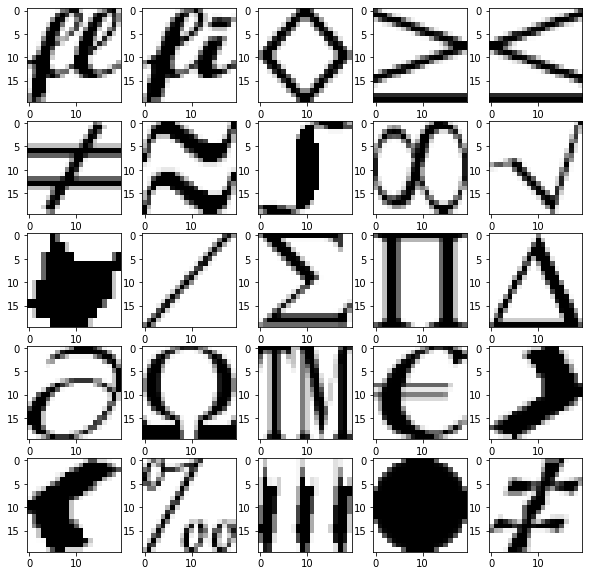

In [766]:
# Scriptb seems like a reasonably similar font to Vivaldi 

script = pd.read_csv("fonts/SCRIPTB.csv")

# This will map all of the characters in scriptB to the same indices as vivaldi, and won't include any characters that don't exist in Vivaldi
script_y, script_X, script_unicode_to_label = makeNumpysWithOtherMap(script, unicode_to_label)
script_loader = makeLoadersNoSplit(script_X, script_y)


plotFirst25(script_X)

In [767]:
print( "Evaluating..." )
evaluate( net, script_loader )

Evaluating...
Accuracy of the network on the test images: 18 %


When running script test data through the net trained on vivaldi training data, the accuracy is ~18%. This makes sense because the vivaldi font is quite "fancy" and curly. The scriptb font is somewhat curly, but it makes sense that the vivaldi network would not be able to classify even close to all of the characters in the scriptb font because the pixels for the 2 fonts will be quite different in a lot of cases. 

4. Train your best network on inputs from the data from at least 2 different fonts.

In [768]:
vivaldi = pd.read_csv("fonts/VIVALDI.csv")
baskerville = pd.read_csv("fonts/BASKERVILLE.csv")
two_fonts = pd.concat([vivaldi, baskerville], axis=0)

two_fonts_y, two_fonts_X, two_fonts_unicode_to_label, two_fonts_label_to_unicode = makeNumpys(two_fonts)
two_fonts_train_loader, two_fonts_test_loader = makeLoaders(two_fonts_X, two_fonts_y)

part_4_net = Net(two_fonts_y.size)

How does your accuracy compare to the 1-font case? 

In [771]:
print( "Training..." )
train( part_4_net, 150, two_fonts_train_loader )

print( "Evaluating..." )
evaluate( part_4_net, two_fonts_test_loader )

Training...
Finished Training
Evaluating...
Accuracy of the network on the test images: 73 %


The accuracy for the 2-font case is ~73%, which is ~10% worse than for the 1-font case. This makes sense because it will be more difficult for the network to classify characters since the characters have different pixel arrangements between the 2 fonts.

What accuracy do you see when testing with inputs from a font you didn't train on?

In [777]:
print( "Evaluating..." )
evaluate( part_4_net, two_fonts_train_loader )

bask_y, bask_X, bask_unicode_to_label, bask_label_to_unicode = makeNumpys(baskerville)
bask_loader = makeLoadersNoSplit(bask_X, bask_y)

print( "Evaluating..." )
evaluate( part_4_net, bask_loader )

script_y_p4, script_X_p4, script_unicode_to_label_p4 = makeNumpysWithOtherMap(script, two_fonts_unicode_to_label)
script_loader_p4 = makeLoadersNoSplit(script_X_p4, script_y_p4)

print( "Evaluating..." )
evaluate( part_4_net, script_loader_p4 )

Evaluating...
Accuracy of the network on the test images: 97 %
Evaluating...
Accuracy of the network on the test images: 89 %
Evaluating...
Accuracy of the network on the test images: 30 %


The accuracy for testing a non-trained font in the 2-font case is ~30%, which is about ~10% better than the accuracy for testing script as a non-trained font in the 1-font case. This makes sense because the net is now using a combination of the 2 fonts to classify the script font, so the accuracy should be higher because the net wasn't trained so specifically to one font. 


Notably, the net performs almost perfectly (~97%) when the training images are run through it again, and very well (~90%) when a font that it was trained on runs through it. 

5. Take a look at some of the characters that have been misclassified.

In [877]:
def evaluateReturnBadPreds( model, testloader ):  
    #load some test data
    # testloader = torch.utils.data.DataLoader( X, batch_size=8,
    #                                           shuffle=True, num_workers=0 )
    correct = 0
    total = 0

    incorrect_preds_and_labels = []
    unsure_preds = []

    with torch.no_grad(): # <- Since we are not training, the model does not need to calculate gradients
        for data in testloader:
            images, labels = data
            outputs = model( images )

            _, predicted = torch.max(outputs.data, 1)

            # vals, indices = torch.topk(outputs.data, 3)
            probablities, top_3_preds = torch.topk(outputs.data, 3)

            soft_max = nn.Softmax(dim=1)
            vals = soft_max(probablities)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i, p in enumerate(predicted):
                if (p != labels[i]):
                    pred_label_pair = []

                    label = labels[i]
                    topk1 = top_3_preds[i][0]
                    topk2 = top_3_preds[i][1]
                    topk3 = top_3_preds[i][2]


                    pred_label_pair.append(p.item())
                    pred_label_pair.append(label.item())
                    pred_label_pair.append(topk1.item())
                    pred_label_pair.append(topk2.item())
                    pred_label_pair.append(topk3.item())

                    incorrect_preds_and_labels.append(pred_label_pair)

                if (vals[i][0].item() < 0.5):

                    pred_val_pair = []
                    label = labels[i]

                    topk1 = top_3_preds[i][0]
                    topk2 = top_3_preds[i][1]
                    topk3 = top_3_preds[i][2]

                    val1 = vals[i][0]
                    val2 = vals[i][1]
                    val3 = vals[i][2]

                    pred_val_pair.append(label.item())
                    pred_val_pair.append(val1.item())
                    pred_val_pair.append(topk1.item())
                    pred_val_pair.append(val2.item())
                    pred_val_pair.append(topk2.item())
                    pred_val_pair.append(val3.item())
                    pred_val_pair.append(topk3.item())

                    unsure_preds.append(pred_val_pair)
                    


    return incorrect_preds_and_labels, unsure_preds
    
def printBadPreds(bad_pred_list):
    for bad in bad_pred_list:
        print ("Predicted: ", bad[0])
        print ("Label: ", bad[1])
        print ("First pred: ", bad[2])
        print ("Second pred: ", bad[3])
        print ("Third pred: ", bad[4])

def graphMisclassified(bad_pred_list, X):

    fig, ax = plt.subplots(30, 4, figsize=(10,50))

    for i, image in enumerate(bad_pred_list):
        
        if (i > 29): break

        ax[i, 0].imshow( np.reshape(X[image[1], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 0].set_title("Label", fontsize=8)
        ax[i, 0].set(frame_on=False)
        ax[i, 0].axis('off')



        ax[i, 1].imshow( np.reshape(X[image[2], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 1].set_title("Pred 1", fontsize=8)
        ax[i, 1].set(frame_on=False)
        ax[i, 1].axis('off')



        ax[i, 2].imshow( np.reshape(X[image[3], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 2].set_title("Pred 2", fontsize=8)
        ax[i, 2].set(frame_on=False)
        ax[i, 2].axis('off')


        ax[i, 3].imshow( np.reshape(X[image[4], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 3].set_title("Pred 3", fontsize=8)    
        ax[i, 3].set(frame_on=False)
        ax[i, 3].axis('off')


    plt.box(False)
    plt.axis('off')

def graphUnsure(unsure_list, X):

    fig, ax = plt.subplots(30, 4, figsize=(10,50))

    for i, image in enumerate(unsure_list):

        if (i > 29): break

        ax[i, 0].imshow( np.reshape(X[image[0], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 0].set_title("Label", fontsize=8)
        ax[i, 0].set(frame_on=False)
        ax[i, 0].axis('off')



        ax[i, 1].imshow( np.reshape(X[image[2], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 1].set_title("Pred 1: " + "{:.0%}".format(image[1]), fontsize=8)
        ax[i, 1].set(frame_on=False)
        ax[i, 1].axis('off')



        ax[i, 2].imshow( np.reshape(X[image[4], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 2].set_title("Pred 2: " + "{:.0%}".format(image[3]), fontsize=8)
        ax[i, 2].set(frame_on=False)
        ax[i, 2].axis('off')


        ax[i, 3].imshow( np.reshape(X[image[6], :, :, :], (20, 20)), cmap='Greys',interpolation='none' )
        ax[i, 3].set_title("Pred 3: " + "{:.0%}".format(image[5]), fontsize=8)    
        ax[i, 3].set(frame_on=False)
        ax[i, 3].axis('off')


    plt.box(False)
    plt.axis('off')


bad preds....


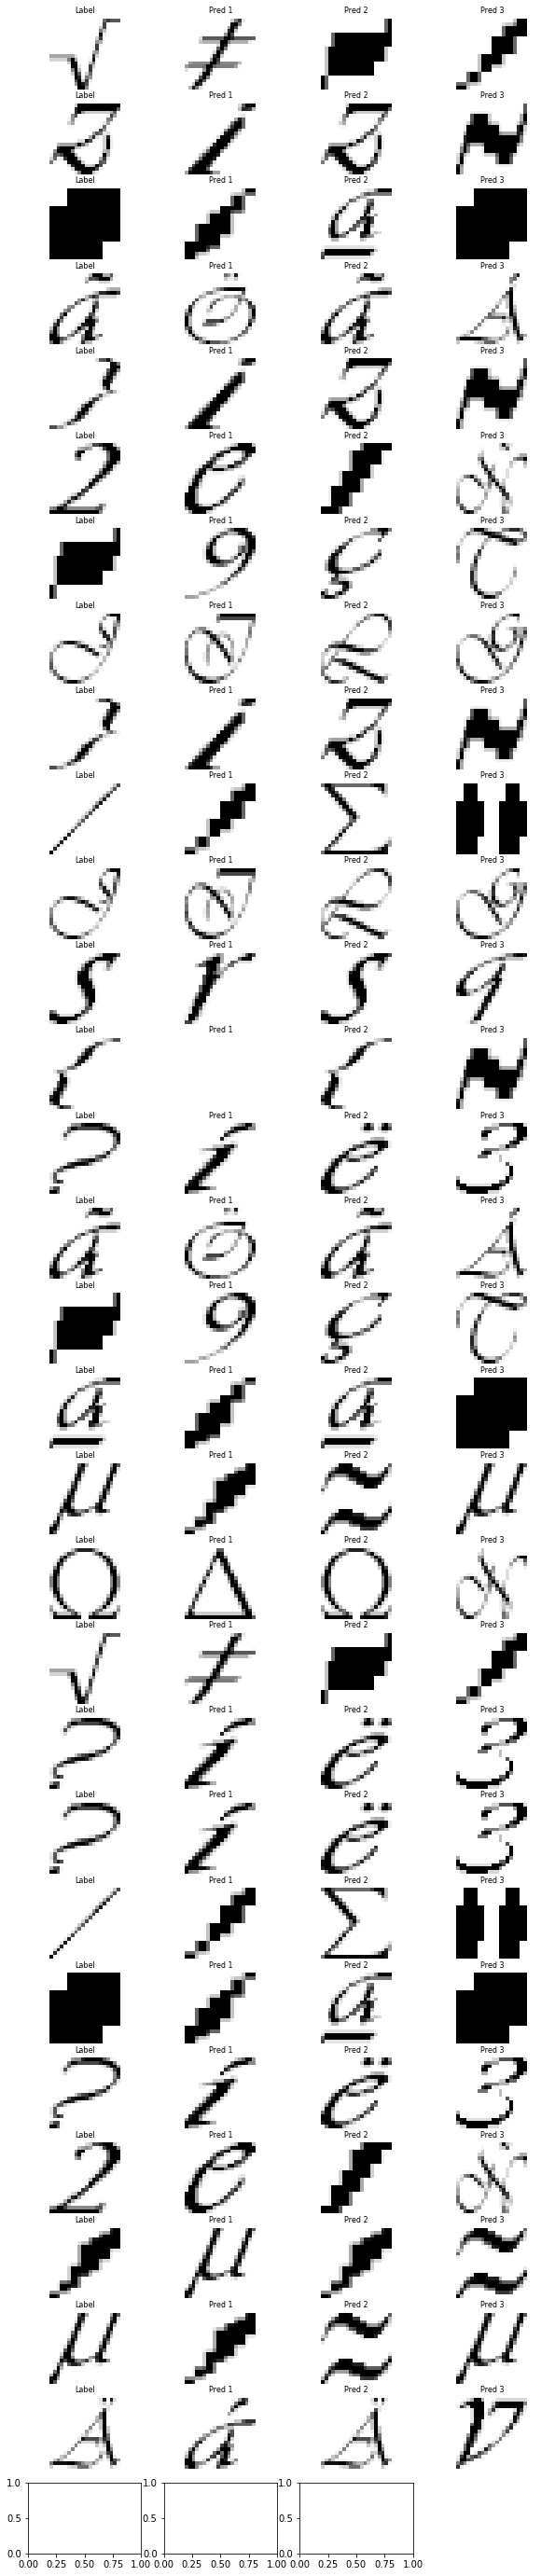

In [878]:
# Get the missclassified characters and unsure characters in the original training/testing set
bad_preds, unsure_preds = evaluateReturnBadPreds(net, test_loader)

# Graph the missclassified characters and unsure characters from part 3
print ("bad preds....")
bad_preds_part_3, unsure_preds_part_3 = evaluateReturnBadPreds(net, script_loader)

graphMisclassified(bad_preds, X)

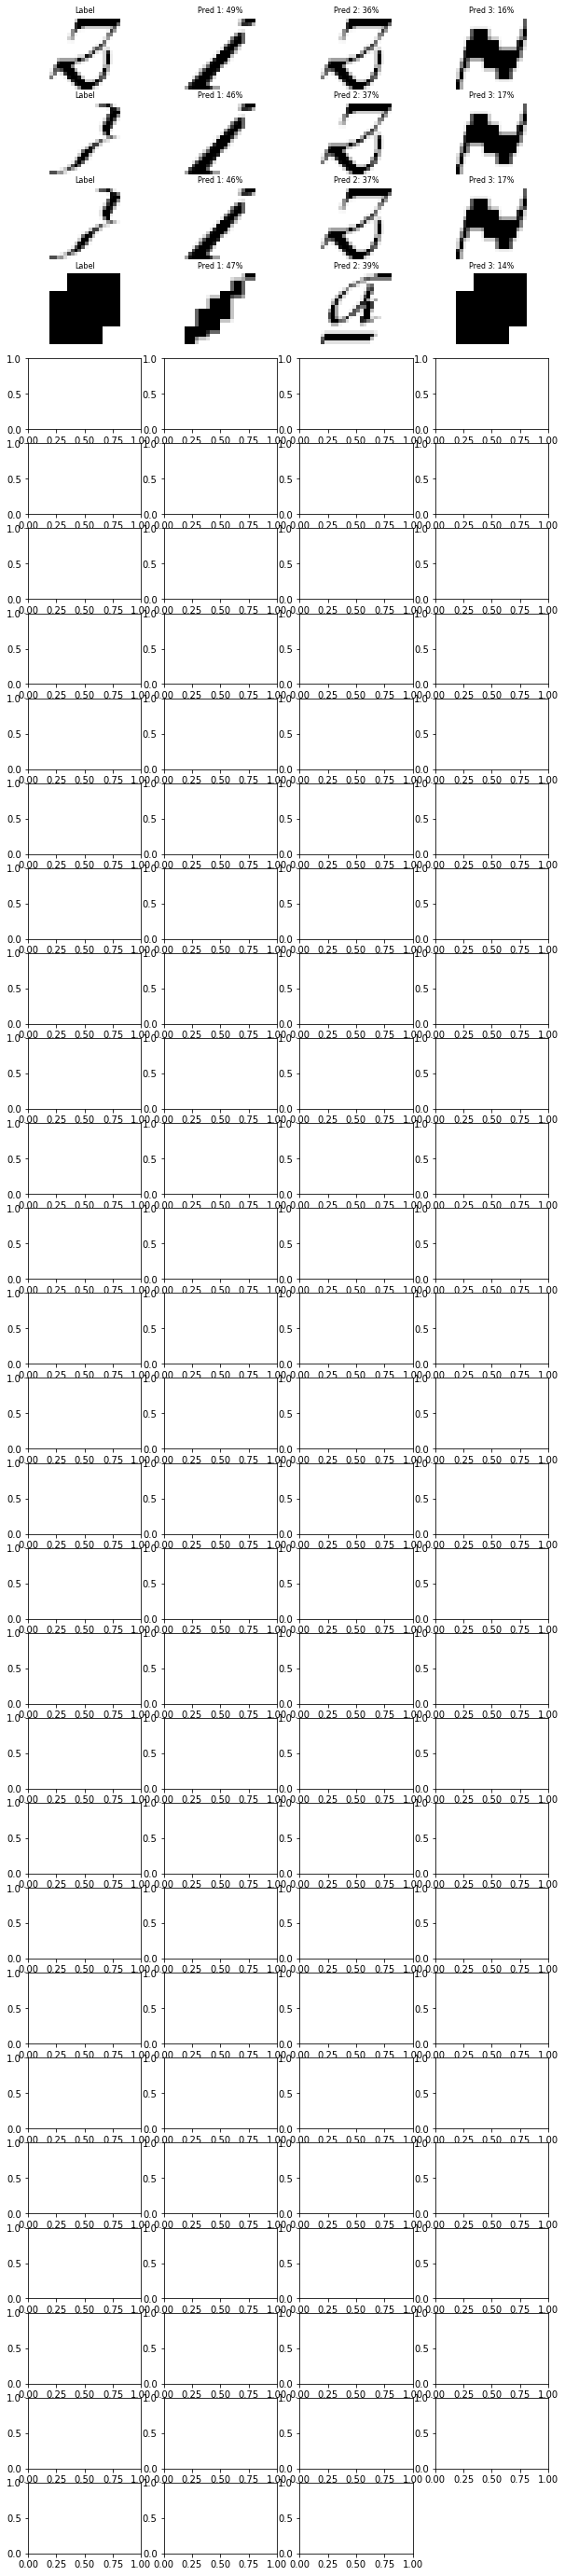

In [879]:
graphUnsure(unsure_preds, X)

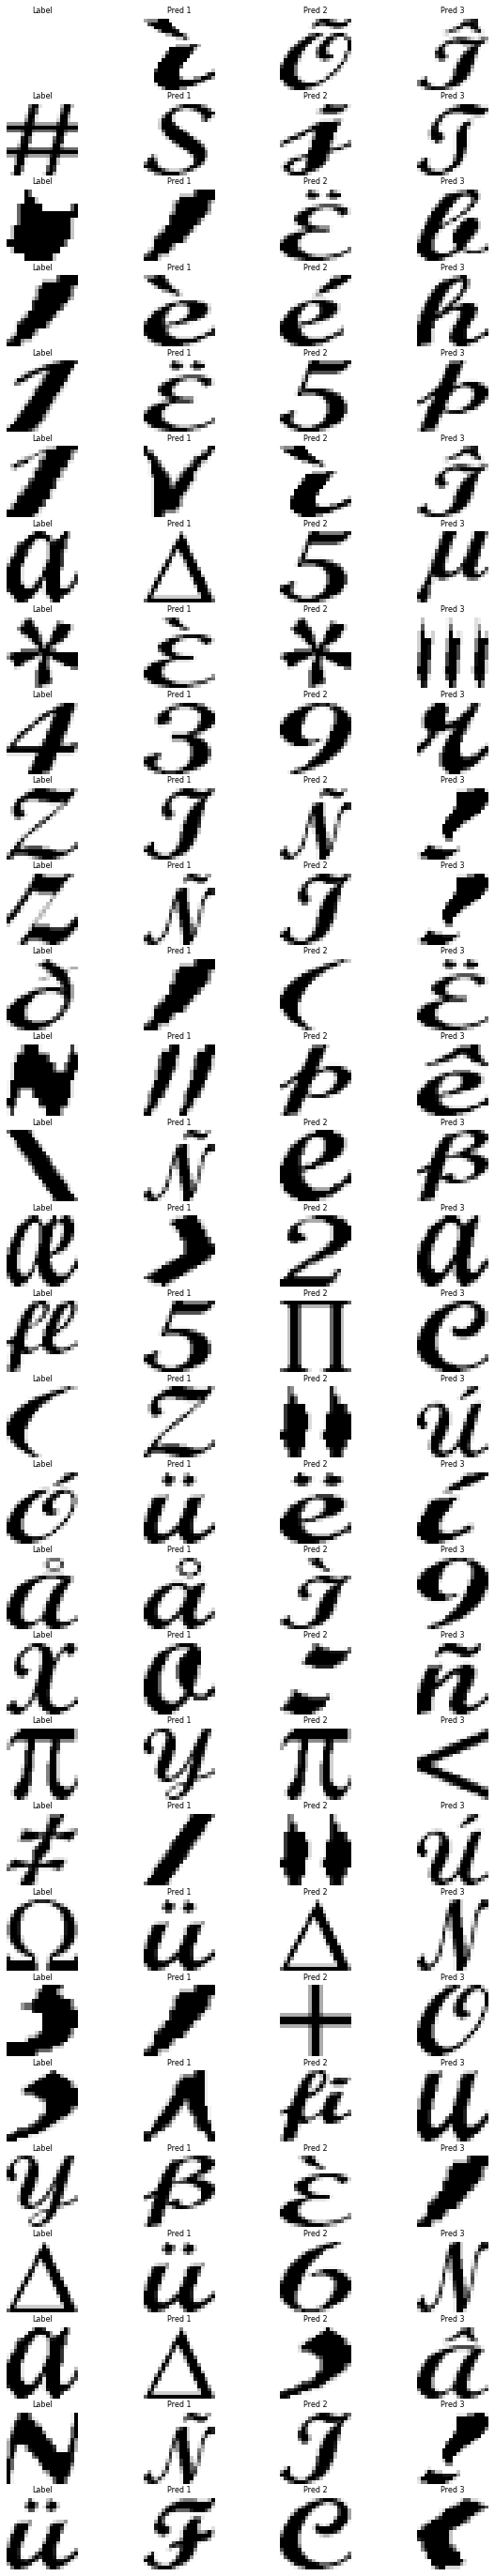

In [880]:
graphMisclassified(bad_preds_part_3, script_X)

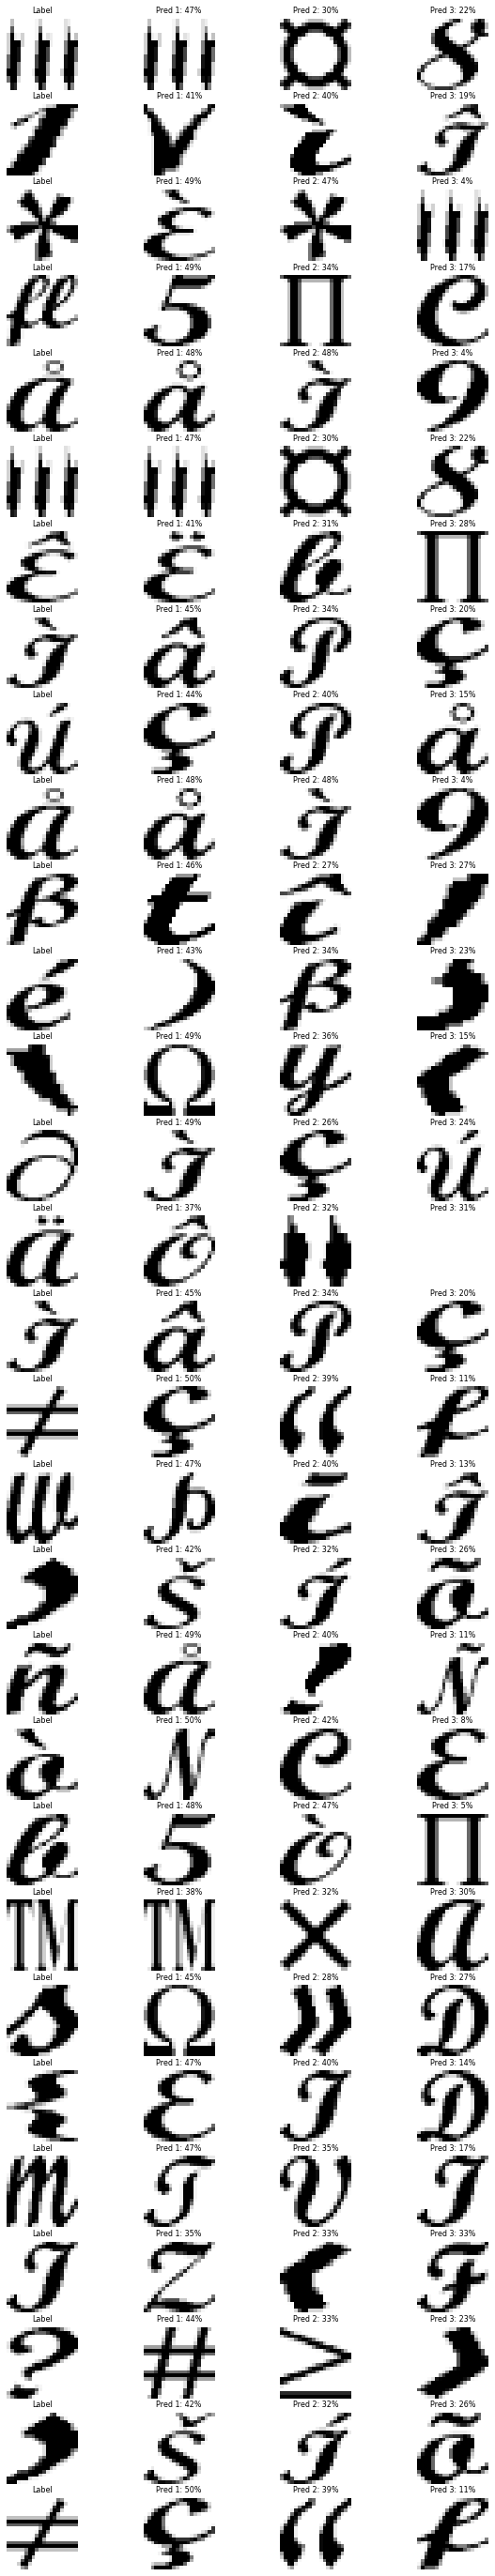

In [881]:
graphUnsure(unsure_preds_part_3, script_X)

Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?

If an image has been misclassified, oftentimes the second or third prediction was correct, meaning that the network came close to making the correct prediction. In a lot of cases, all of the top 3 predicted characters look quite similar to each other, although this isn't always the case. In cases where the predictions don't look similar to the character's actual label, it's an indication that the network wasn't trained very well on those characters.


There are quite a few instances where the network is unsure of the result, and when the network can't decide between characters (i.e. the first one has less than 50% probability), it tends to have quite a bit of overlap with the misclassified characters. Clearly the network hasn't been trained well enough and is confused on what the character should be, so sometimes it gets lucky and classifies it correctly, and other times the most probable prediction is incorrect. 

#### Part 4: Denoising

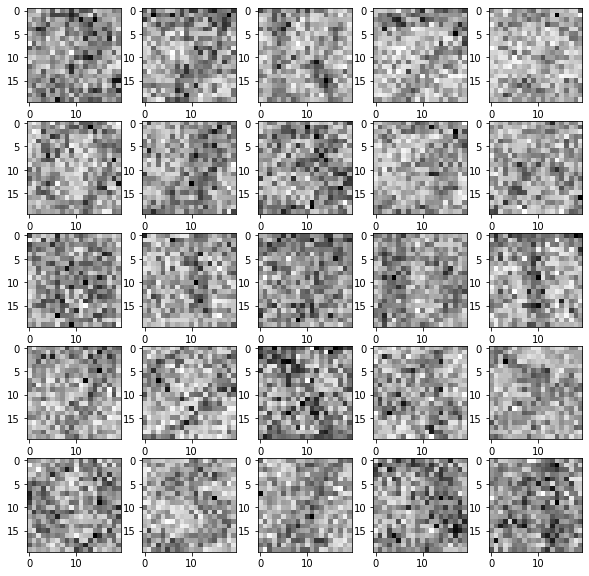

In [742]:
times = pd.read_csv("fonts/TIMES.csv")
# century = pd.read_csv("fonts/CENTURY.csv")


y_times, X_times, unicode_to_label_times, label_to_unicode_times = makeNumpys(times)

mu=0.0
std = 0.75

def gaussian_noise(X,mu,std):
    noise = np.random.normal(mu, std, size = X.shape)
    X_noisy = X + noise
    return X_noisy 

noisy_X = gaussian_noise(X_times, mu, std)

plotFirst25(noisy_X)

noisy_loader = makeLoadersNoSplit(noisy_X, y_times)
normal_loader = makeLoadersNoSplit(X_times, y_times)



In [716]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        #the padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        #output is 8x 28x28 images
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 20//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

denoiser = Denoiser() # treat these as just 28 D vectors

In [743]:
#same as we did before except for the reshaping.  CNNs understand 2D images, so we don't want to flatten

# mean-squared error loss
# this is the normal "least squares" error function, divided by the number of data points
criterion = nn.MSELoss()

def trainDenoiser(model, epochs, train_loader):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

        
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            # print("data", data)

            #same as yesterday, except we're not even looking at the labels!
            # since we're not using a CNN, we need to "flatten" the input images
            batch_features = data[0]

            # print("features", batch_features)
        
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(batch_features)
            #print(batch_features.shape)
            #print(outputs.shape)
            # compute training reconstruction loss
            # again, same idea as yesterday, but we're measuring the error slightly differently
            # how well does the reconstructed image match the input image?
            train_loss = criterion(outputs, batch_features)
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateDenoiser(model, test_loader):
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

In [744]:
trainDenoiser(denoiser, 200, noisy_loader)
evaluateDenoiser(denoiser, normal_loader)

epoch : 1/200, loss = 0.57874858
epoch : 2/200, loss = 0.57841716
epoch : 3/200, loss = 0.57826366
epoch : 4/200, loss = 0.57819257
epoch : 5/200, loss = 0.57813205
epoch : 6/200, loss = 0.57802169
epoch : 7/200, loss = 0.57798472
epoch : 8/200, loss = 0.57788993
epoch : 9/200, loss = 0.57792262
epoch : 10/200, loss = 0.57785813
epoch : 11/200, loss = 0.57783655
epoch : 12/200, loss = 0.57773676
epoch : 13/200, loss = 0.57775048
epoch : 14/200, loss = 0.57771161
epoch : 15/200, loss = 0.57765580
epoch : 16/200, loss = 0.57764590
epoch : 17/200, loss = 0.57766584
epoch : 18/200, loss = 0.57768738
epoch : 19/200, loss = 0.57754066
epoch : 20/200, loss = 0.57758570
epoch : 21/200, loss = 0.57753908
epoch : 22/200, loss = 0.57752987
epoch : 23/200, loss = 0.57757505
epoch : 24/200, loss = 0.57752790
epoch : 25/200, loss = 0.57755022
epoch : 26/200, loss = 0.57749487
epoch : 27/200, loss = 0.57746345
epoch : 28/200, loss = 0.57749092
epoch : 29/200, loss = 0.57738778
epoch : 30/200, loss = 

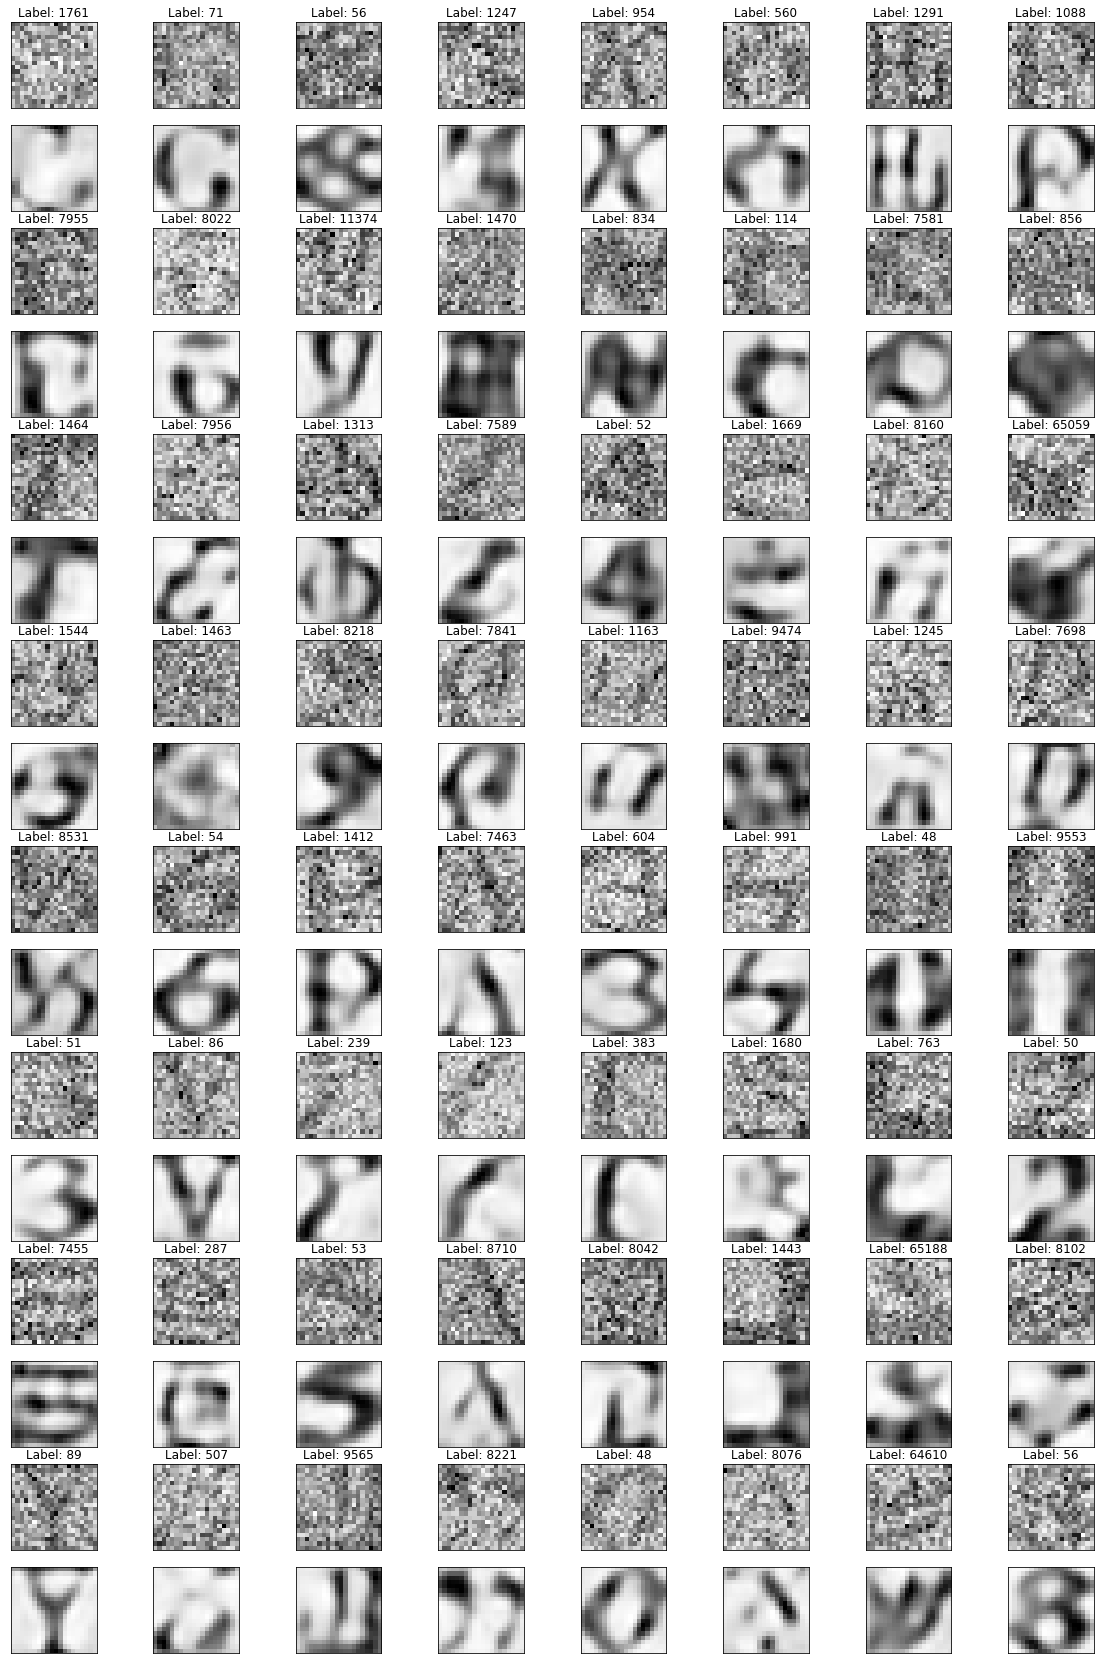

In [749]:
def drawComparisonsCNN(model, test_loader, unicode_map):
    plt.figure(figsize=(20, 30))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]


        _, labels = batch
        #print(images.shape)

        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):

                label = label_to_unicode[labels[j].item()]

                #draw the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.set_title("Label: " + str(label))
            
                #and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisonsCNN(denoiser, noisy_loader, label_to_unicode_times)

Disclaimer: The graph might depict different characters than the specific ones I analyze in the following, but the same general principles hold true. 

It is clear from this visual that the denoiser had the desired effect. The noisy images are not classifiable with the human eye (they simply look like random grey static), but the auto encoder comes to recognize them well enough to recreate them much more intelligibly, therefore doing a good job distinguishing which characters are which (better than a human could do on the noisy images). The outputs from the denoiser look (in most cases) like actual characters, or they at least resemble characters. This is even more clear when we look at the labels of the characters (converted back into their unicode characters) and compare them to the actual characters. For example, Unicode 48 represents the digit 0, which we can see resembles a 0 in the denoiser. 57 represents a "9" and 55 represents a "7", which are also very clear. In fact, there are several digits represented in the denoiser graph which look very much like the number they are labeled as. We can distinguish other characters, as well - 960 represents pi, which is clear in the graph. The representation for 578 looks much like its corresponding unicode character, and same with 902. It's really interesting to look up the actual corresponding unicode characters and see how they map onto the denoiser, because it does an amazingly accurate job of picking out the characters. 